In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import xarray as xr
from PyBNG import PyBNG
import shapely
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import re
import requests
import zipfile as zpf
from tqdm import tqdm
from PIL import Image
from ADMS_functions import extract_dataset_time_axis, plot_timeseries, PointXYZ_to_latlon, plot_on_map, plot_in_grid_box, process_timeseries_dataset

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


Specify the run number (and data folder):

In [2]:
run = "015"
home_folder = f"/home/users/mwlw3/ADMS-Urban/2019_hourly_met/all_regions/{run}/"
gws_folder = f"/gws/nopw/j04/htap2/mwlw3/ADMS-Urban/2019_hourly_met/all_regions/{run}/"

folder = gws_folder


files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]

processed_coordinates_filepath = path.join(folder, "raw_processed_coordinates.nc")
processed_regions_folder = path.join(folder, "raw_processed_regions")
processed_months_folder = path.join(folder, "raw_processed_months")
daily_offgrid_folder = path.join(folder, "daily_offgrid")

This section of code processes the raw ADMS-Urban outputs (poorly structured netCDF files) to netCDF files with lat/lon coordinate indexing. The resulting folder, `raw_processed_regions`, contains files which correspond to the original spatially split regions.

In [12]:
# Processing from raw ADMS-Urban outputs to a netCDF file with useful attributes and latitude/longitude coordinates
# One region at a time

if not path.exists(processed_regions_folder):
    makedirs(processed_regions_folder)
print("Checking region files...")
for i in tqdm(range(len(files))):
    region = files[i].split(".")[-2]
    region_filepath = path.join(folder, "raw_processed_regions", f"{region}.nc")
    print(region_filepath)
    if not path.exists(region_filepath):
        region_ds = process_timeseries_dataset(xr.open_dataset(files[i]))
        region_ds.to_netcdf(region_filepath)
print("Removing raw files.")
[remove(file) for file in files]
print("Done.")

0it [00:00, ?it/s]

Checking region files...
Removing raw files.
Done.


This section of code processes the spatially split regional files and creates netCDF files which are separated temporally instead of spatially. The resulting folder, `raw_processed_months`, contains a file for each month of the year. Each file contains the whole Greater London region.

In [98]:
files = [path.join(processed_regions_folder, file) for file in listdir(processed_regions_folder)]

if not path.exists(processed_months_folder):
    makedirs(processed_months_folder)

for month_i in tqdm(range(12)):
    month = month_i+1
    monthly_regions = []
    for files_i in range(len(files)):
        ds = xr.open_dataset(files[files_i])
        year = int(re.findall("\d\d\d\d", folder)[0])
        ds = ds.isel(time=(ds.datetime.dt.year==year))
        ds = ds.isel(time=(ds.datetime.dt.month==month))
        monthly_regions.append(ds)

    print("Concatenating regions...")
    monthly_ds = xr.concat(monthly_regions, dim="space")
    print("Saving monthly netCDF...")
    monthly_ds.to_netcdf(path.join(processed_months_folder, f"month_{str(month).zfill(2)}.nc"))

  0%|          | 0/12 [00:00<?, ?it/s]

Concatenating regions...


  0%|          | 0/12 [00:29<?, ?it/s]


KeyboardInterrupt: 

Load a monthly file for plotting:

In [3]:
month = 1
monthly_ds = xr.open_dataset(path.join(processed_months_folder, f"month_{str(month).zfill(2)}.nc"))

In [4]:
monthly_ds.where(monthly_ds != -999)

<xarray.Dataset>
Dimensions:            (time: 744, space: 214452)
Coordinates:
    datetime           (time) datetime64[ns] 2019-01-01 ... 2019-01-31T23:00:00
    latitude           (space) float64 51.44 51.44 51.44 ... 51.57 51.57 51.57
    longitude          (space) float64 0.1185 0.1272 0.1359 ... -0.1952 -0.1951
Dimensions without coordinates: time, space
Data variables:
    NOx                (time, space) float32 29.86 31.25 32.46 ... 42.72 88.43
    NO2                (time, space) float32 7.037 7.435 7.76 ... 16.64 26.86
    PM10               (time, space) float32 11.53 11.77 11.99 ... 19.02 23.88
    PM2.5              (time, space) float32 7.554 7.661 7.757 ... 13.47 15.68
    CO2                (time, space) float32 1.714e+04 1.805e+04 ... 3.156e+04
    wind_speed_at_10m  (space, time) float32 3.084 3.084 5.089 ... 4.575 4.575
    wind_direction     (space, time) float32 290.0 280.0 290.0 ... 80.0 70.0
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London
    Project_Name:               2019 meteorology, grid (600 m) and road-orien...
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               29/3/2022
    Time_Created:               16:46:25

In [5]:
new_gdf = gpd.GeoDataFrame(monthly_ds.mean(dim="time")["NO2"].values, 
                 columns=["2019_month_mean_NO2"], 
                 geometry=gpd.points_from_xy(monthly_ds.longitude.values, monthly_ds.latitude.values))

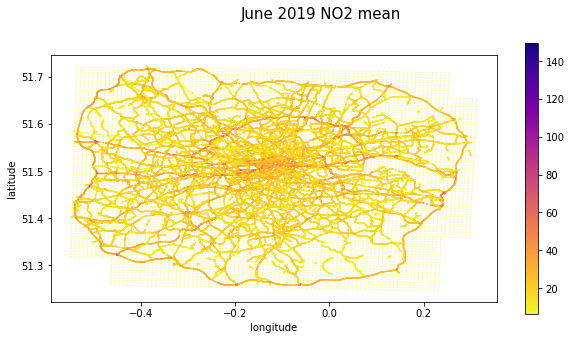

In [13]:
month_name = dt.datetime.strptime(f"{month}", "%m").strftime("%B")
plot_in_grid_box(new_gdf, "2019_month_mean_NO2", f"{month_name} 2019 NO2 mean")

Aggregate the data from hourly to daily mean:

In [ ]:
files = [path.join(processed_months_folder, file) for file in listdir(processed_months_folder) if file.split(".")[-1]=="nc"]

if not path.exists(daily_offgrid_folder):
    makedirs(daily_offgrid_folder)

daily_regions = []    
    
for i in tqdm(range(len(files))):
    monthly_ds = xr.open_dataset(files[i])
    daily_mean_ds = monthly_ds.where(monthly_ds != -999).swap_dims({"time":"datetime"}).resample(datetime="1D").mean(dim="datetime")
    daily_regions.append(daily_mean_ds)

print("Concatenating regions...")
daily_ds = xr.concat(daily_regions, dim="space")
print("Saving daily netCDF...")
daily_ds.to_netcdf(path.join(daily_offgrid_folder, f"daily_offgrid.nc"))
print("Done.")

100%|██████████| 12/12 [03:56<00:00, 19.69s/it]


Concatenating regions...


In [3]:
daily_ds = xr.open_dataset(path.join(daily_offgrid_folder, f"daily_offgrid.nc"))

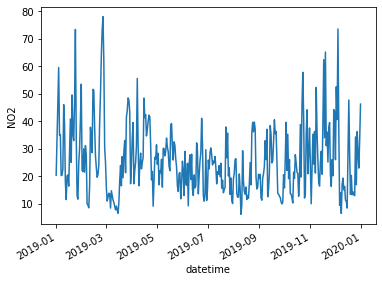

In [4]:
daily_ds.NO2.mean(dim="space").plot()
plt.show()

In [5]:
new_gdf = gpd.GeoDataFrame(daily_ds.NO2.mean(dim="datetime").values, 
                 columns=["2019_mean_NO2"], 
                 geometry=gpd.points_from_xy(daily_ds.longitude.values, daily_ds.latitude.values))

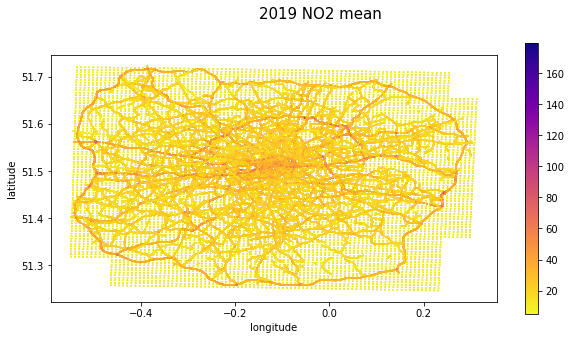

In [8]:
plot_in_grid_box(new_gdf, "2019_mean_NO2", f"2019 NO2 mean")